In [4]:
from tinyYoloV2Fused import TinyYoloV2Fused
from tinyyolov2 import TinyYoloV2
from tinyYoloV2FusedPruned import TinyYoloV2FusedPruned
from utils.fuse_helper import fuse_conv_and_bn
from utils.dataloader import VOCDataLoaderPerson, VOCDataLoader
from utils.loss import YoloLoss
from utils.yolo import nms, filter_boxes
from utils.viz import display_result
import torch
import tqdm
from utils.pruning import *
from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes

In [2]:
loader = VOCDataLoaderPerson(train=False, batch_size=1)

In [3]:
def fuse_model(o_model):
    f_model = TinyYoloV2Fused(num_classes=o_model.num_classes)
    
    f_model.conv1 = fuse_conv_and_bn(o_model.conv1, o_model.bn1)
    f_model.conv2 = fuse_conv_and_bn(o_model.conv2, o_model.bn2)
    f_model.conv3 = fuse_conv_and_bn(o_model.conv3, o_model.bn3)
    f_model.conv4 = fuse_conv_and_bn(o_model.conv4, o_model.bn4)
    f_model.conv5 = fuse_conv_and_bn(o_model.conv5, o_model.bn5)
    f_model.conv6 = fuse_conv_and_bn(o_model.conv6, o_model.bn6)
    f_model.conv7 = fuse_conv_and_bn(o_model.conv7, o_model.bn7)
    f_model.conv8 = fuse_conv_and_bn(o_model.conv8, o_model.bn8)
    f_model.conv9 = o_model.conv9  # No BN layer to fuse
    
    return f_model

In [16]:


original_model = TinyYoloV2(num_classes=1)
original_model.load_state_dict(torch.load("model_epoch_14.pt"))
fused_model = fuse_model(original_model)
sd = fused_model.state_dict()
for key in sd.keys():
    print(key, sd[key].shape)

anchors torch.Size([5, 2])
conv1.weight torch.Size([16, 3, 3, 3])
conv1.bias torch.Size([16])
conv2.weight torch.Size([32, 16, 3, 3])
conv2.bias torch.Size([32])
conv3.weight torch.Size([64, 32, 3, 3])
conv3.bias torch.Size([64])
conv4.weight torch.Size([128, 64, 3, 3])
conv4.bias torch.Size([128])
conv5.weight torch.Size([256, 128, 3, 3])
conv5.bias torch.Size([256])
conv6.weight torch.Size([512, 256, 3, 3])
conv6.bias torch.Size([512])
conv7.weight torch.Size([1024, 512, 3, 3])
conv7.bias torch.Size([1024])
conv8.weight torch.Size([1024, 1024, 3, 3])
conv8.bias torch.Size([1024])
conv9.weight torch.Size([30, 1024, 1, 1])
conv9.bias torch.Size([30])


In [14]:
sd_temp = prune_and_densify(sd, 0.1)

pruned_model = TinyYoloV2FusedPruned(num_classes=1)
pruned_model.load_state_dict(sd_temp)

odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])


<All keys matched successfully>

In [15]:
for key in sd_temp.keys():
    print(key, sd_temp[key].shape)

anchors torch.Size([5, 2])
conv1.weight torch.Size([16, 3, 3, 3])
conv1.bias torch.Size([16])
conv2.weight torch.Size([28, 16, 3, 3])
conv2.bias torch.Size([28])
conv3.weight torch.Size([57, 28, 3, 3])
conv3.bias torch.Size([57])
conv4.weight torch.Size([115, 57, 3, 3])
conv4.bias torch.Size([115])
conv5.weight torch.Size([230, 115, 3, 3])
conv5.bias torch.Size([230])
conv6.weight torch.Size([460, 230, 3, 3])
conv6.bias torch.Size([460])
conv7.weight torch.Size([921, 460, 3, 3])
conv7.bias torch.Size([921])
conv8.weight torch.Size([921, 921, 3, 3])
conv8.bias torch.Size([921])
conv9.weight torch.Size([30, 921, 1, 1])
conv9.bias torch.Size([30])


In [9]:
# compare the output of the original model and the fused model


original_model.eval()
fused_model.eval()
pruned_model.eval()

test_precision_original = []
test_recall_original = []
test_precision_fused = []
test_recall_fused = []
test_precision_pruned = []
test_recall_pruned = []
test_AP_original = []
test_AP_fused = []
test_AP_pruned = []


for i, (img, target) in enumerate(loader):
    with torch.no_grad():
        original_out = original_model(img)
        original_out = filter_boxes(original_out, 0.2)
        original_out = nms(original_out, 0.25)
        original_precision, original_recall = precision_recall_levels(target[0], original_out[0])
        test_precision_original.append(original_precision)  
        test_recall_original.append(original_recall)
        
        
        fused_out = fused_model(img)
        fused_out = filter_boxes(fused_out, 0.2)
        fused_out = nms(fused_out, 0.25)
        fused_precision, fused_recall = precision_recall_levels(target[0], fused_out[0])
        test_precision_fused.append(fused_precision)
        test_recall_fused.append(fused_recall)
        
        
        pruned_out = pruned_model(img)
        pruned_out = filter_boxes(pruned_out, 0.2)
        pruned_out = nms(pruned_out, 0.25)
        pruned_precision, pruned_recall = precision_recall_levels(target[0], pruned_out[0])
        test_precision_pruned.append(pruned_precision)
        test_recall_pruned.append(pruned_recall)
        

test_AP_original = [ap(test_precision_original, test_recall_original)]
test_AP_fused = [ap(test_precision_fused, test_recall_fused)]
test_AP_pruned = [ap(test_precision_pruned, test_recall_pruned)]

print("Original model AP: ", test_AP_original, "Fused model AP: ", test_AP_fused, "Pruned model AP: ", test_AP_pruned)
        


Original model AP:  [0.48821982907393463] Fused model AP:  [0.48821982907393463] Pruned model AP:  [0.24035041272944502]


In [5]:
#get torch number of cores
torch.set_num_threads(8)

True


  0%|          | 0/10 [00:00<?, ?it/s]

odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.4156608810842682
AP:  0.42320725496128714
AP:  0.4200596595757888
AP:  0.4174681725084955
AP:  0.4112268827078214
AP:  0.41041467204865323
AP:  0.41033659345653145


 10%|█         | 1/10 [11:18<1:41:45, 678.44s/it]

AP:  0.4051968166394946
Best model AP:  0.42320725496128714 with ratio:  0.0 and AP 0.42320725496128714
odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.40937889666811955
AP:  0.4097867200139927
AP:  0.41399420520978847
AP:  0.41093961767455783
AP:  0.4157105104129787
AP:  0.41561159063246456
AP:  0.41097765169734846


 20%|██        | 2/10 [21:16<1:24:07, 630.90s/it]

AP:  0.4070960099403554
Best model AP:  0.4157105104129787 with ratio:  0.05 and AP 0.4157105104129787
odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.33187113066145324
AP:  0.3327070629489984
AP:  0.3382473932877159
AP:  0.3370417161243774
AP:  0.39581175117648704
AP:  0.39367346557341226
AP:  0.3926912528024452


 30%|███       | 3/10 [35:20<1:24:58, 728.40s/it]

AP:  0.3896785792397658
Best model AP:  0.39581175117648704 with ratio:  0.1 and AP 0.39581175117648704
odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.25265083632019114
AP:  0.2527417027417027
AP:  0.3198597512105577
AP:  0.31746666161148696
AP:  0.31833807147651233
AP:  0.32817269598183585
AP:  0.32672018628239824


 40%|████      | 4/10 [47:18<1:12:25, 724.28s/it]

AP:  0.329411346972671
Best model AP:  0.329411346972671 with ratio:  0.15000000000000002 and AP 0.329411346972671
odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.16525130335614205
AP:  0.231513523936239
AP:  0.2348143439429282
AP:  0.24594007551836858
AP:  0.2451972069646801
AP:  0.24388590903487853
AP:  0.2508901002564597


 50%|█████     | 5/10 [57:14<56:29, 677.95s/it]  

AP:  0.3115575082755711
Best model AP:  0.3115575082755711 with ratio:  0.2 and AP 0.3115575082755711
odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.16956527642011515
AP:  0.1667549147387857
AP:  0.1646275866705974
AP:  0.17219439013793855
AP:  0.17193263277940699
AP:  0.1712890554288404
AP:  0.2304426413771764


 60%|██████    | 6/10 [1:08:23<45:00, 675.07s/it]

AP:  0.2292752680967131
Best model AP:  0.2304426413771764 with ratio:  0.25 and AP 0.2304426413771764
odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.09090909090909091
AP:  0.16005824372759855
AP:  0.16794332210998875
AP:  0.16698213332117898
AP:  0.1661114343641225
AP:  0.1645378866537021
AP:  0.16349694230358594


 70%|███████   | 7/10 [1:19:02<33:09, 663.19s/it]

AP:  0.1708413096013902
Best model AP:  0.1708413096013902 with ratio:  0.30000000000000004 and AP 0.1708413096013902
odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.15878181456138443
AP:  0.1575491942595437
AP:  0.15668178197748087
AP:  0.1671771478223091
AP:  0.1662997098480969


 80%|████████  | 8/10 [1:28:54<21:20, 640.47s/it]

AP:  0.1653953004507439
Best model AP:  0.1671771478223091 with ratio:  0.35000000000000003 and AP 0.1671771478223091
odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.15567575487890387


 90%|█████████ | 9/10 [1:38:04<10:12, 612.33s/it]

AP:  0.1539396986053572
Best model AP:  0.15567575487890387 with ratio:  0.4 and AP 0.15567575487890387
odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.09090909090909091
AP:  0.09090909090909091


100%|██████████| 10/10 [1:45:35<00:00, 633.57s/it]

AP:  0.09090909090909091
Best model AP:  0.09090909090909091 with ratio:  0.45 and AP 0.09090909090909091


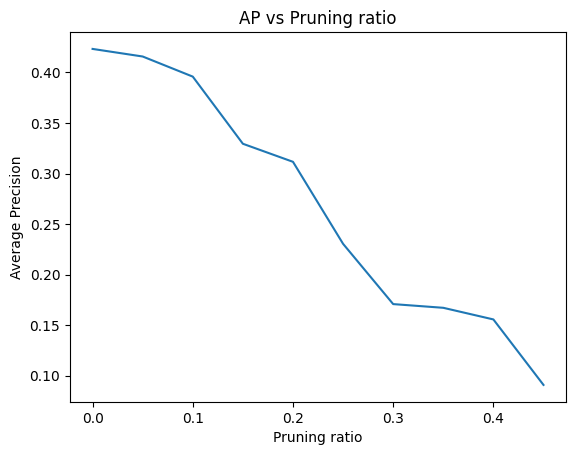

In [7]:
#finetuning the pruned model
# just last layer
import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

ratios = [0.0] + [0.05 * i for i in range(1, 10)]
train_loader = VOCDataLoaderPerson(train=True, batch_size=32)


AP_ratios = []

for ratio in tqdm.tqdm(ratios):
    original_model = TinyYoloV2(num_classes=1)
    original_model.load_state_dict(torch.load("model_epoch_14.pt"))
    fused_model = fuse_model(original_model)
    sd = fused_model.state_dict()
    
    
    model = TinyYoloV2FusedPruned(num_classes=1)
    
    sd_temp = prune_and_densify(sd, ratio)
    model.load_state_dict(sd_temp)
    model.to(device)
    # freeze all layers except the last two 
    for name, param in model.named_parameters():
        param.requires_grad = "conv9" in name or "conv8" in name
    
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0002)
    criterion = YoloLoss(anchors = model.anchors)
    
    test_precision_pruned = []
    test_recall_pruned = []
    test_AP_pruned = []
    model_sd = []
    
    for epoch in range(8):
        model.train()
        for i, (img, target) in enumerate(train_loader):
            img, target = img.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(img, yolo=False)
            loss, _ = criterion(output, target)
            loss.backward()
            optimizer.step()        
        model.eval()

        for i, (img, target) in enumerate(loader):
            with torch.no_grad():
                img, target = img.to(device), target.to(device)
                
                pruned_out = model(img, yolo=True)
                pruned_out = filter_boxes(pruned_out, 0.2)
                pruned_out = nms(pruned_out, 0.25)
                pruned_precision, pruned_recall = precision_recall_levels(target[0], pruned_out[0])
                test_precision_pruned.append(pruned_precision)
                test_recall_pruned.append(pruned_recall)
                
        test_AP_pruned.append(ap(test_precision_pruned, test_recall_pruned))
        print("AP: ", test_AP_pruned[-1]) 
        model_sd.append(model.state_dict())
    
    #determine the best model
    best_model = model_sd[test_AP_pruned.index(max(test_AP_pruned))]
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), "pruned_model_ratio_{}.pt".format(ratio))
    print("Best model AP: ", max(test_AP_pruned), "with ratio: ", ratio, "and AP", max(test_AP_pruned)) 
    AP_ratios.append((ratio, max(test_AP_pruned)))
    
# display the AP for different ratios in a plot
import matplotlib.pyplot as plt
ratios = [x[0] for x in AP_ratios]
APs = [x[1] for x in AP_ratios]
plt.plot(ratios, APs)
plt.xlabel("Pruning ratio")
plt.ylabel("Average Precision")
plt.title("AP vs Pruning ratio")
plt.show()

In [9]:
#write the ap tuples to a file
with open("AP_ratios.txt", "w") as f:
    for item in AP_ratios:
        f.write(str(item) + "\n")

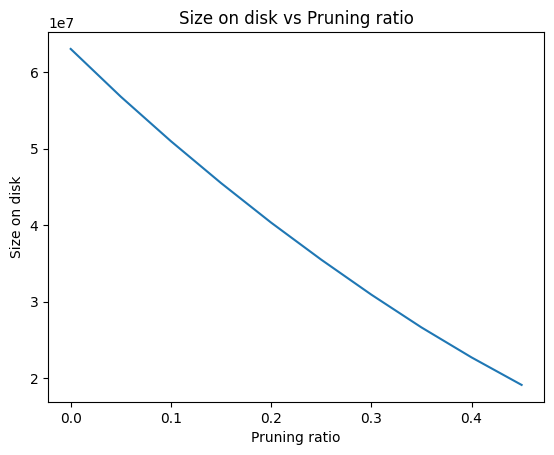

In [10]:
#for all pruned models, determine the size on disk, and plot it against the ratio
import os
import matplotlib.pyplot as plt
ratios = [0.0] + [0.05 * i for i in range(1, 10)]
sizes = []
for ratio in ratios:
    size = os.path.getsize("pruned_model_ratio_{}.pt".format(ratio))
    sizes.append(size)
    
plt.plot(ratios, sizes)
plt.xlabel("Pruning ratio")
plt.ylabel("Size on disk")
plt.title("Size on disk vs Pruning ratio")
plt.show()


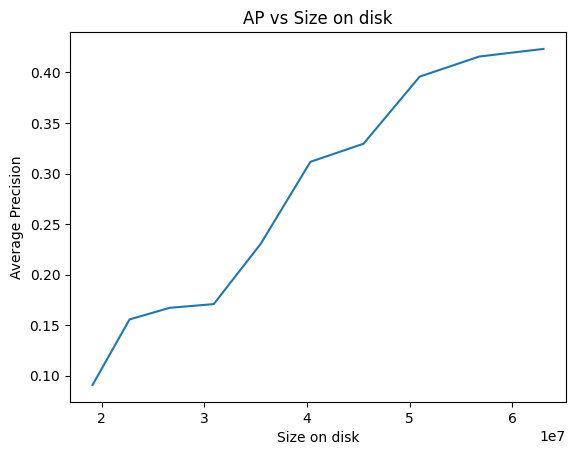

In [11]:
#plot the ap vs the size on disk
plt.plot(sizes, APs)
plt.xlabel("Size on disk")
plt.ylabel("Average Precision")
plt.title("AP vs Size on disk")
plt.show()